In [ ]:
pip install -U statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 13.5 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import itertools

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
df = pd.read_csv('BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', index_col='Date', parse_dates=True)

In [ ]:
#df.index.freq = 'B'

In [ ]:
df.shape

(2787, 5)

In [ ]:
# Assume the forecast horizon we care about is 12
# Validate over 10 steps
h = 12
steps = 10
Ntest = len(df) - h - steps + 1

In [ ]:
# Configuration hyperparameters to try
trend_type_list = ['add', 'mul']
seasonal_type_list = ['add', 'mul']
damped_trend_list = [True, False]
init_method_list = ['estimated', 'heuristic', 'legacy-heuristic']
use_boxcox_list = [True, False, 0]

In [ ]:
# NOTE: statsmodels documentation states that 'log' is an acceptable input
#       for use_boxcox. This is false.

In [ ]:
def walkforward(
    trend_type,
    seasonal_type,
    damped_trend,
    init_method,
    use_boxcox,
    debug=False):

  # store errors
  errors = []
  seen_last = False
  steps_completed = 0

  for end_of_train in range(Ntest, len(df) - h + 1):
    # We don't have to manually "add" the data to our dataset
    # Just index it at the right points - this is a "view" not a "copy"
    # So it doesn't take up any extra space or computation
    train = df.iloc[:end_of_train]
    test = df.iloc[end_of_train:end_of_train + h]

    if test.index[-1] == df.index[-1]:
      seen_last = True
    
    steps_completed += 1

    hw = ExponentialSmoothing(
        train['Closing Price (USD)'],
        initialization_method=init_method,
        trend=trend_type,
        damped_trend=damped_trend,
        seasonal=seasonal_type,
        seasonal_periods=12,
        use_boxcox=use_boxcox)
    res_hw = hw.fit()

    # compute error for the forecast horizon
    fcast = res_hw.forecast(h)
    error = mean_squared_error(test['Closing Price (USD)'], fcast)
    errors.append(error)
  
  if debug:
    print("seen_last:", seen_last)
    print("steps completed:", steps_completed)

  return np.mean(errors)


In [ ]:
# test our our function
walkforward('add', 'add', False, 'legacy-heuristic', 0, debug=True)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, f

seen_last: True
steps completed: 10


17643779.083226405

In [ ]:
# Iterate through all possible options (i.e. grid search)
tuple_of_option_lists = (
    trend_type_list,
    seasonal_type_list,
    damped_trend_list,
    init_method_list,
    use_boxcox_list,
)
for x in itertools.product(*tuple_of_option_lists):
  print(x)

('add', 'add', True, 'estimated', True)
('add', 'add', True, 'estimated', False)
('add', 'add', True, 'estimated', 0)
('add', 'add', True, 'heuristic', True)
('add', 'add', True, 'heuristic', False)
('add', 'add', True, 'heuristic', 0)
('add', 'add', True, 'legacy-heuristic', True)
('add', 'add', True, 'legacy-heuristic', False)
('add', 'add', True, 'legacy-heuristic', 0)
('add', 'add', False, 'estimated', True)
('add', 'add', False, 'estimated', False)
('add', 'add', False, 'estimated', 0)
('add', 'add', False, 'heuristic', True)
('add', 'add', False, 'heuristic', False)
('add', 'add', False, 'heuristic', 0)
('add', 'add', False, 'legacy-heuristic', True)
('add', 'add', False, 'legacy-heuristic', False)
('add', 'add', False, 'legacy-heuristic', 0)
('add', 'mul', True, 'estimated', True)
('add', 'mul', True, 'estimated', False)
('add', 'mul', True, 'estimated', 0)
('add', 'mul', True, 'heuristic', True)
('add', 'mul', True, 'heuristic', False)
('add', 'mul', True, 'heuristic', 0)
('add

In [ ]:
best_score = float('inf')
best_options = None
for x in itertools.product(*tuple_of_option_lists):
  score = walkforward(*x)

  if score < best_score:
    print("Best score so far:", score)
    best_score = score
    best_options = x

In [ ]:
print("best score:", best_score)

trend_type, seasonal_type, damped_trend, init_method, use_boxcox = best_options
print("trend_type", trend_type)
print("seasonal_type", seasonal_type)
print("damped_trend", damped_trend)
print("init_method", init_method)
print("use_boxcox", use_boxcox)

best score: 13758000.70819276
trend_type add
seasonal_type add
damped_trend False
init_method estimated
use_boxcox False


In [ ]:
Ntest = 100
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [ ]:
hw = ExponentialSmoothing(
    train['Closing Price (USD)'],
    initialization_method='estimated',
    trend='add',
    damped_trend=False,
    seasonal='mul',
    seasonal_periods=12,
    use_boxcox=False)
res_hw = hw.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [ ]:
df.loc[train_idx, 'TrainPred'] = res_hw.fittedvalues
df.loc[test_idx, 'Forecast'] = res_hw.forecast(Ntest)

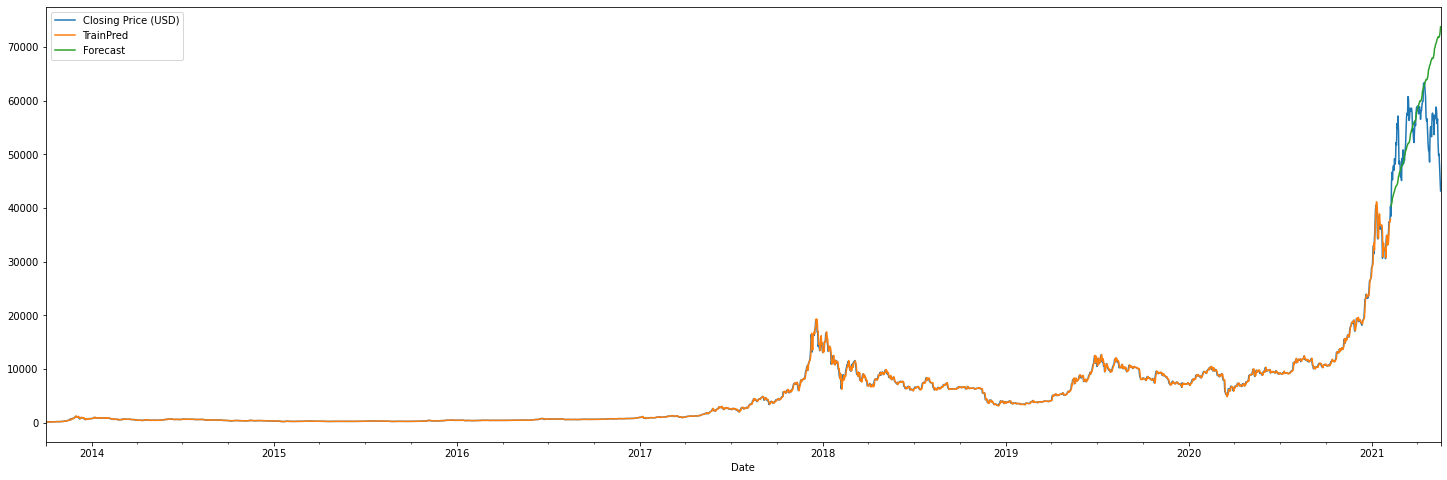

In [ ]:
df[['Closing Price (USD)', 'TrainPred', 'Forecast']].plot(figsize=(25, 8));